In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, lfilter
from scipy.ndimage.filters import uniform_filter1d

In [2]:
dataset1_path = 'data'
ffsr = dataset1_path + '/finger_finger_slow_richard.csv'
ffst = dataset1_path + '/finger_finger_slow_toma.csv'
fwsr = dataset1_path + '/finger_wrist_slow_richard.csv'
fwst = dataset1_path + '/finger_wrist_slow_toma.csv'
wwsr = dataset1_path + '/wrist_wrist_slow_richard.csv'
wwst = dataset1_path + '/wrist_wrist_slow_toma.csv'
fwbt = dataset1_path + '/finger_watch_bottom_toma1.csv'

ds1_files = [ffsr, ffst, fwsr, fwst, wwsr, wwst, fwbt]

In [3]:
def parse_csv(filename):
    data1 = []
    data2 = []
    with open(filename, 'r') as file_handler:
        for line in file_handler:
            line = line.strip()
            if len(line) > 0:
                line_parts = line.split(',')
                data1.append(float(line_parts[0]))
                data2.append(float(line_parts[1]))
    return data1, data2

def parse_csv_timestamped(filename):
    samples = []
    millis = []
    data1 = []
    data2 = []
    with open(filename, 'r') as file_handler:
        for line in file_handler:
            line = line.strip()
            if len(line) > 0:
                line_parts = line.split(',')
                samples.append(float(line_parts[0]))
                millis.append(float(line_parts[1]))
                data1.append(float(line_parts[2]))
                data2.append(float(line_parts[3]))
    return samples, millis, data1, data2

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
def normalize_data(data, mode="simple"):
    if mode == "center":
        mean = np.mean(data)
        std = np.std(data)
        data -= mean
        data /= std
        return data
    if mode == "simple":
        return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
def rolling_mean(signal, windowsize):
    rol_mean = uniform_filter1d(np.asarray(signal, dtype='float'), size=int(windowsize))
    return rol_mean

def peak_detection(signal, windowsize, scale=1.15):
    peaks_x = []
    peaks_y = []
    
    # scale rolling mean
    rm = rolling_mean(signal, windowsize)
    mov_avg = [x*scale for x in rm]
    peak_window = [] # stores indicies of peak region of interest
    pw_start = 0
    peak_x = 0
    peak_y = 0

    for i, dp in enumerate(signal):
        if dp < mov_avg[i] and len(peak_window) > 1: 
            # find peak and peak index
            for px in peak_window:
                if signal[px] > peak_y:
                    peak_x = px
                    peak_y = signal[px]
            # record peaks
            peaks_x.append(peak_x)
            peaks_y.append(peak_y)
            # reset
            peak_window = []
            peak_x = 0
            peak_y = 0
        elif dp > mov_avg[i]:
          # add to region of interest
          peak_window.append(i)   

    return peaks_x, peaks_y

def get_bpm(signal, peaks_x, sample_rate):
    N = len(signal)
    seconds = N / sample_rate
    bpm = 60 * len(peaks_x) / seconds
    return bpm

In [7]:
def get_sampling_rate(samps, millis):
    index = 0
    start = millis[index]
    prev = start
    
    samps_per_sec = []
    
    for _ in range(len(samps)//1000):
        start = millis[index]
        prev_ind = index
        for i, m in enumerate(millis):
            if m - start >= 1000 and prev - start < 1000:
                index = i
            prev = m
        samps_per_sec.append(samps[index] - samps[prev_ind])
    
    return np.mean(samps_per_sec)

In [8]:
# keys: file
# values: dictionary with path, silicone_ts, ppg_ts, cc, ac
dataset = {}

# some ac and cc numbers are not approriate
for f in ds1_files:
    temp = {}
    temp["filepath"] = f
    if f == fwbt:
        s, m, silicone, ppg = parse_csv_timestamped(f)
        temp["sr"] = get_sampling_rate(s, m)
    else:
        silicone, ppg = parse_csv(f)
    temp["vib"] = silicone
    temp["ppg"] = ppg
    dataset[f] = temp
    
print(dataset.keys())
print(dataset[fwbt]["sr"])

dict_keys(['data/finger_finger_slow_richard.csv', 'data/finger_finger_slow_toma.csv', 'data/finger_wrist_slow_richard.csv', 'data/finger_wrist_slow_toma.csv', 'data/wrist_wrist_slow_richard.csv', 'data/wrist_wrist_slow_toma.csv', 'data/finger_watch_bottom_toma1.csv'])
277.57142857142856


In [9]:
def lowpass(sig, cutoff, fs, order=4):
    b_lp, a_lp = butter(order, cutoff, btype='low', analog=False, fs=fs)
    return lfilter(b_lp, a_lp, sig)

def highpass(sig, cutoff, fs, order=4):
    b_hp, a_hp = butter(order, cutoff, btype='high', analog=False, fs=fs)
    return lfilter(b_hp, a_hp, sig)

def bandpass(sig, cutoffs, fs, order=4, mode='bp'):
    if mode == 'combo':
        b_lp, a_lp = butter(order, cutoffs[1], btype='low', analog=False, fs=fs)
        temp = lfilter(b_lp, a_lp, sig)
        b_hp, a_hp = butter(order, cutoffs[0], btype='high', analog=False, fs=fs)
        return lfilter(b_hp, a_hp, temp)
    else: # mode == 'bp'
        b_bp, a_bp = butter(order, cutoffs, btype='bandpass', analog=False, fs=fs)
        return lfilter(b_bp, a_bp, sig)

In [10]:
def compare_peaks(ppg, vib, start, end, sr, w_ppg=100, w_vib=1000, print_bpm=True):
    
    ppg_x, ppg_y = peak_detection(ppg, w_ppg)
    vib_rm = rolling_mean(vib, w_vib)
    vib_x, vib_y = signal.find_peaks(vib_rm)
#     vib_x, vib_y = peak_detection(vib, w_vib)
    
    if print_bpm:
        print('ppg bpm', get_bpm(ppg[250:], ppg_x, sr))
        print('vib bpm', get_bpm(vib[250:], vib_x, sr))
    
#     print(compare_peak_times(ppg_x, vib_x, sr))
    
    plt.figure()
    plt.scatter(ppg_x, vib_x)
    plt.show()
    
    n_ppg = normalize_data(ppg[start:end], mode="simple")
    n_vib = normalize_data(vib[start:end], mode="simple")
    n_rm = normalize_data(vib_rm[start:end], mode="simple")
    
    plt.figure(figsize=(14, 8))
    plt.plot(n_ppg, c='b', label='ppg')
    plt.plot(n_vib, c='g', label='vib')
#     plt.plot(n_rm, c='c', label='vib_rm')
    for x_p in ppg_x:
        if x_p > start and x_p < end:
            plt.axvline(x=x_p-start, c='r')
    for x_v in vib_x:
        if x_v > start and x_v < end:
            plt.axvline(x=x_v-start, c='y')
    plt.legend()
    plt.show()
    
def compare_peak_times(ppg_x, vib_x, sr):
    differences = []
    for dp in ppg_x:
            differences.append(ppg_x - vib_x)
    mean = np.mean(differences)
    std = np.std(differences)
    return mean, std

ppg bpm 61.064931401978356
vib bpm 61.064931401978356


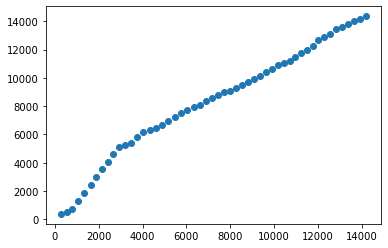

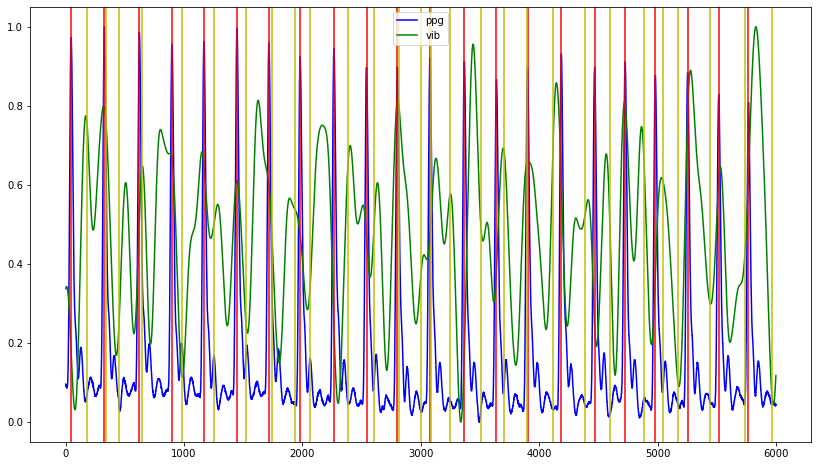

In [11]:
compare_peaks(dataset[fwbt]["ppg"], bandpass(dataset[fwbt]["vib"], [0.5, 2], dataset[fwbt]["sr"]), 6000, 12000, dataset[fwbt]["sr"])

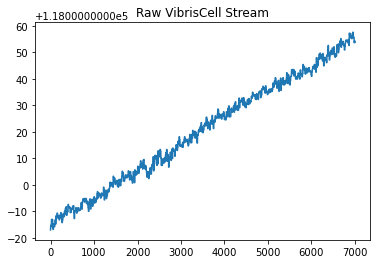

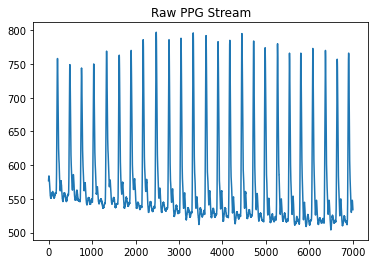

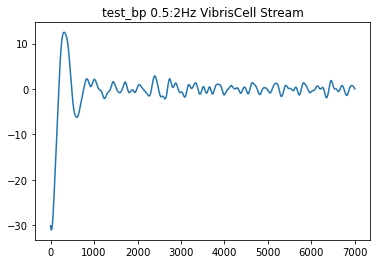

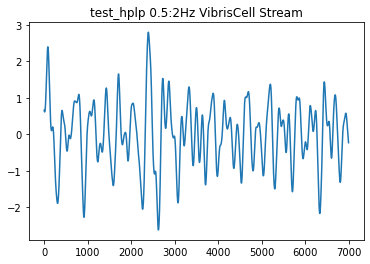

In [12]:
### Backlog
f = fwbt
sig = dataset[f]["vib"]
p_sig = dataset[f]['ppg']
    
# lowpass below 2Hz
b_lp, a_lp = butter(4, 2, btype='low', analog=False, fs=297)
fwsr_hr_lp = lfilter(b_lp, a_lp, sig)

# bandpass between 0.5:2Hz
b_bp, a_bp = butter(4, [0.5, 2], btype='bandpass', analog=False, fs=297)
fwsr_hr_bp = lfilter(b_bp, a_bp, sig)

# handpass above 0.5Hz
b_hp, a_hp = butter(4, 0.5, btype='high', analog=False, fs=297)
fwsr_hr_hp = lfilter(b_hp, a_hp, sig)

fwsr_hr_lp_hp = lfilter(b_hp, a_hp, fwsr_hr_lp)
fwsr_hr_hp_lp = lfilter(b_lp, a_lp, fwsr_hr_hp)

start = 3000
end = 10000

plt.figure()
plt.title("Raw VibrisCell Stream")
plt.plot(sig[start:end])
plt.show()

plt.figure()
plt.title("Raw PPG Stream")
plt.plot(p_sig[start:end])
plt.show()

# test_lp = lowpass(sig, 2, 297)
# test_hp = highpass(sig, 0.5, 297)
test_bp = bandpass(sig, [0.5, 2], 297)
test_hplp = bandpass(sig, [0.5, 2], 297, mode='combo')

# plt.figure()
# plt.title("test_lp 2Hz VibrisCell Stream")
# plt.plot(test_lp[start:end])
# plt.show()

# plt.figure()
# plt.title("Highpassed 0.5Hz VibrisCell Stream")
# plt.plot(fwsr_hr_hp[start:end])
# plt.show()

# plt.figure()
# plt.title("test_hp 0.5Hz VibrisCell Stream")
# plt.plot(test_hp[start:end])
# plt.show()

# plt.figure()
# plt.title("Bandpassed 0.5:2Hz VibrisCell Stream")
# plt.plot(fwsr_hr_bp[start:end])
# plt.show()

plt.figure()
plt.title("test_bp 0.5:2Hz VibrisCell Stream")
plt.plot(test_bp[start:end])
plt.show()

# plt.figure()
# plt.title("LP, HP 0.5:2Hz VibrisCell Stream")
# plt.plot(fwsr_hr_lp_hp[start:end])
# plt.show()

plt.figure()
plt.title("test_hplp 0.5:2Hz VibrisCell Stream")
plt.plot(test_hplp[start:end])
plt.show()


##################################

# ppg_sig = dataset[fwsr]["ppg"]
# # sil_sig = dataset[fwsr]["vib"]

# sil_sig = bandpass(dataset[fwsr]["vib"], [0.5, 2], 297)

# start = 3000
# end = 12000

# x, y = peak_detection(ppg_sig, 100)
# vib_rm = rolling_mean(sil_sig, 1000)
# vib_x, vib_y = signal.find_peaks(vib_rm)

# print(get_bpm(ppg_sig, x, 297))
# print(get_bpm(sil_sig, vib_x, 297))

# n_ppg = normalize_data(ppg_sig[start:end], mode="simple")
# n_sil = normalize_data(sil_sig[start:end], mode="simple")
# n_rm = normalize_data(vib_rm[start:end], mode="simple")

# plt.figure(figsize=(14, 8))
# plt.plot(n_ppg, c='b', label='ppg')
# plt.plot(n_sil, c='g', label='vib')
# plt.plot(n_rm, c='c', label='vib_rm')
# for x_coor in x:
#     if x_coor > start and x_coor < end:
#         plt.axvline(x=x_coor-start, c='r')
# for x_coor in vib_x:
#     if x_coor > start and x_coor < end:
#         plt.axvline(x=x_coor-start, c='y')
# plt.legend()
# plt.show()